# Stack Exchange Data Analysis

In this notebook, I intend to perform various analyses on a sample of stack exchange datasets. I arbitrarily chose the data from the 3D priniting stackexchange website which is available [here](https://archive.org/download/stackexchange). 


In [30]:
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
plt.style.use('ggplot')
%matplotlib inline

In [28]:
%config InlineBackend.figure_format = 'svg'

The following code turns the XML files into pandas dataframes.

In [2]:
class XML2DataFrame:

    def __init__(self, xml_file):
        self.root = ET.parse(xml_file).getroot()

    def parse_root(self, root):
        return [self.parse_element(child) for child in iter(root)]

    def parse_element(self, element, parsed=None):
        if parsed is None:
            parsed = dict()
        for key in element.keys():
            parsed[key] = element.attrib.get(key)
        if element.text:
            parsed[element.tag] = element.text
        for child in list(element):
            self.parse_element(child, parsed)
        return parsed

    def process_data(self):
        structure_data = self.parse_root(self.root)
        return pd.DataFrame(structure_data)
xml_file='Posts.xml'
xml2df = XML2DataFrame(xml_file)
df = xml2df.process_data()

In [3]:
df.head()

,AcceptedAnswerId,AnswerCount,Body,ClosedDate,CommentCount,CreationDate,FavoriteCount,Id,LastActivityDate,LastEditDate,LastEditorUserId,OwnerDisplayName,OwnerUserId,ParentId,PostTypeId,Score,Tags,Title,ViewCount
0,51,2,<p>When I've printed an object I've had to cho...,NaN,6,2016-01-12T18:45:19.963,NaN,1,2017-10-31T02:31:08.560,NaN,NaN,NaN,16,NaN,1,9,<resolution><speed><quality>,How to obtain high resolution prints in a shor...,204
1,12,4,"<p>I would like to buy a 3D printer, but I'm c...",NaN,1,2016-01-12T18:45:51.287,2,2,2016-11-15T16:16:11.163,2016-11-15T16:16:11.163,334,NaN,20,NaN,1,23,<print-material><safety><health>,Is 3D printing safe for your health?,1504
2,152,3,<p>I know the minimum layer height will effect...,NaN,5,2016-01-12T18:46:22.083,1,3,2016-09-19T15:41:06.537,2016-01-12T22:00:36.347,11,NaN,11,NaN,1,16,<quality><resolution>,How important is the minimum layer height on a...,1063
3,1289,4,<p>Plastic is used in 3D FDM/FFF printing part...,NaN,0,2016-01-12T18:50:55.973,2,4,2016-06-10T13:32:20.493,2016-06-09T02:10:35.890,98,NaN,16,NaN,1,15,<fdm><material><print-material><metal-parts>,Are there any metals that exhibit a large glas...,175
4,77,5,<p>What are the main differences when using AB...,NaN,5,2016-01-12T18:53:53.623,4,5,2017-08-02T09:49:07.263,2016-01-15T17:02:37.707,20,NaN,11,NaN,1,31,<filament><abs><fdm><pla>,How is PLA different from ABS material?,1177


Let's take a look at some of the informations about the posts dataframe.

In [4]:
df.columns

Index(['AcceptedAnswerId', 'AnswerCount', 'Body', 'ClosedDate', 'CommentCount',
       'CreationDate', 'FavoriteCount', 'Id', 'LastActivityDate',
       'LastEditDate', 'LastEditorUserId', 'OwnerDisplayName', 'OwnerUserId',
       'ParentId', 'PostTypeId', 'Score', 'Tags', 'Title', 'ViewCount'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4017 entries, 0 to 4016
Data columns (total 19 columns):
AcceptedAnswerId    739 non-null object
AnswerCount         1329 non-null object
Body                4017 non-null object
ClosedDate          70 non-null object
CommentCount        4017 non-null object
CreationDate        4017 non-null object
FavoriteCount       263 non-null object
Id                  4017 non-null object
LastActivityDate    4017 non-null object
LastEditDate        1660 non-null object
LastEditorUserId    1660 non-null object
OwnerDisplayName    10 non-null object
OwnerUserId         4012 non-null object
ParentId            2438 non-null object
PostTypeId          4017 non-null object
Score               4017 non-null object
Tags                1329 non-null object
Title               1329 non-null object
ViewCount           1329 non-null object
dtypes: object(19)
memory usage: 596.4+ KB


In [6]:
df.CreationDate=pd.to_datetime(df.CreationDate)

In [7]:
df.ViewCount=df.ViewCount.astype('float')
df.AnswerCount=df.AnswerCount.astype('float')
df.Score=df.Score.astype('float')

In the following cells, we explore some intersting basic insights about the dynamics of posting on such forums

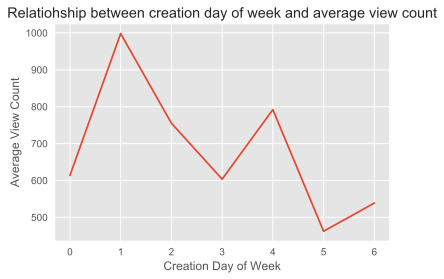

In [47]:
plt.figure(figsize=(6,4))
df.groupby(df.CreationDate.dt.dayofweek).ViewCount.mean().plot()
plt.xlabel('Creation Day of Week')
plt.ylabel('Average View Count')
plt.title('Relatiohship between creation day of week and average view count')

The figure above suggests that the posts submitted on Tuesdays and Fridays are much more likely to be viewed. This is interesring as it is indicative of the natural human pattern of being lethargic on Mondays and being more in the mood and productive on Fridays and Tuesdays.

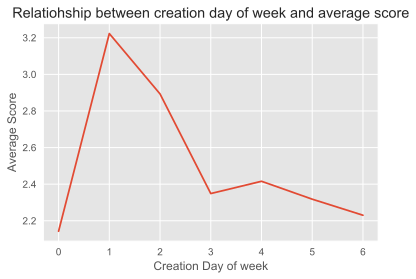

In [35]:
plt.figure(figsize=(6,4))
df.groupby(df.CreationDate.dt.dayofweek).Score.mean().plot()
plt.xlabel('Creation Day of week')
plt.ylabel('Average Score')
plt.title('Relatiohship between creation day of week and average score')

The figure above is in accordance with the previous figure suggesting that Tuesdays and Fridays are the days to go on such forums

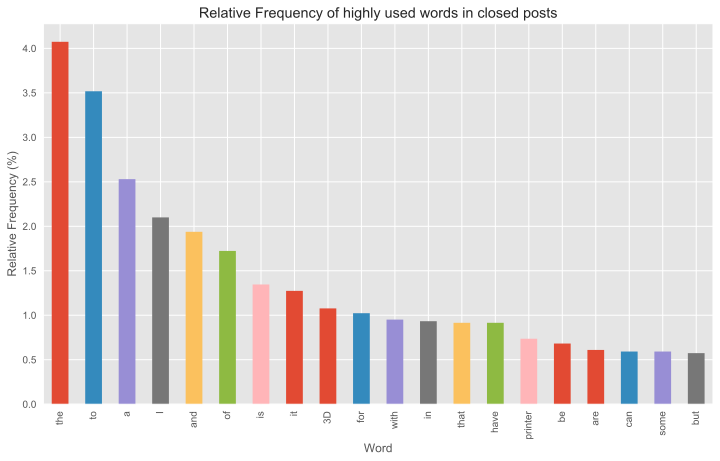

In [44]:
from collections import Counter
plt.figure(figsize=(12, 7))
closed_word_count = pd.Series(Counter(str(df[~df.ClosedDate.isna()].Body.tolist()).split())).sort_values(
    ascending=False)
(100*closed_word_count/sum(closed_word_count)).head(20).plot('bar')
plt.xlabel('Word')
plt.ylabel('Relative Frequency (%)')
plt.title('Relative Frequency of highly used words in closed posts')

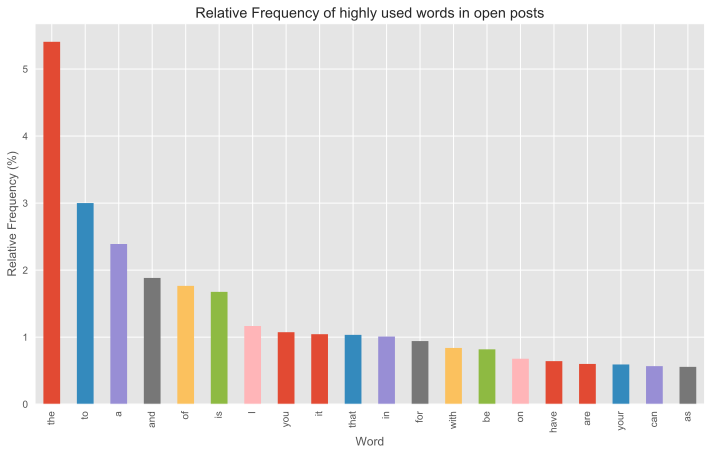

In [45]:
plt.figure(figsize=(12,7))
open_word_count=pd.Series(Counter(str(df[df.ClosedDate.isna()].Body.tolist()).split())).sort_values(
    ascending=False)
(100*open_word_count/sum(open_word_count)).head(20).plot('bar')
plt.xlabel('Word')
plt.ylabel('Relative Frequency (%)')
plt.title('Relative Frequency of highly used words in open posts')

It is very interesting to see that the word "I" is much more frequently used in closed down posts as opposed to "you" which is not used often indicating that posts with highly subjective tones to them are more likely to be closed down.